In [6]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

# TRANSVERSE
def plot_lscale(directory,flist,ist=0,ien=-1,savename=None,thresh=0.2):
    
    fig,ax = plt.subplots(1,4,figsize=(10,3), dpi=200)
    lscales = np.zeros([3,len(flist)])
    
    for count,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        if inp.rr==1: pass
        else: 
            ic,yc = get_centerline(directory,y,int(tID))
            eta -= yc/dtheta 
        
        
        # Get transverse decorr lengthscale
        autocorr = np.fromfile(fname, sep=' ',count=-1)
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0] #[yc,yc+offset,yc-offset]
        ly,i1,i2 = get_lscale(y,autocorr,thresh=thresh)
        ax[0].plot(eta, autocorr,alpha=1,label='tID=%s,t=%d'%(tID,time))
        
        # Get 99% lengthscale
        utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
        L99,tmp1,tmp2 = get_L99(-y,utilde)

        ax[0].plot([eta[i1],eta[i2]],[thresh,thresh],'k-*')
        ax[1].plot(eta, utilde/inp.du, alpha=1)
        ax[2].plot(time,L99,'k*',)
        ax[2].plot(time,dtheta,'k^',)
        ax[2].plot(time,ly,'*',)        
        ax[3].plot(time,ly/L99,'k*',)        
        ax[3].plot(time,ly/dtheta,'k^',)        

        xmax = L99/dtheta/2.
        ax[0].set_title('Autocorrelation')
        ax[0].set_xlim([-xmax,xmax])
        ax[0].set_xlabel(r'$\eta$')
        ax[1].set_title(r'$\tilde{u}/\Delta \bar{u}$')
        ax[1].set_xlim([-xmax,xmax])
        ax[1].set_xlabel(r'$\eta$')
        ax[2].set_xlabel('t')
        ax[2].legend([r'$L_{99}$',r'$\delta_\theta$','$L_y$'])
        ax[3].legend([r'$L_y/L_{99}$',r'$L_y/\delta_\theta$'])
        ax[3].set_xlabel('t')
        
        lscales[0,count] = ly
        lscales[1,count] = ly/L99
        lscales[2,count] = ly/dtheta
        namelist = ['L','L/L99','L/dtheta']
        
    for a in ax: a.grid(True)

    if savename is None:
        for i,name in enumerate(namelist):
            print(name)
            print('{}: [{}, {}],'.format(inp.Mc,np.mean(lscales[i,ist:ien]),np.std(lscales[i,ist:ien])))
    else:
        fig.savefig(savename,dpi=200, bbox_inches='tight')
        plt.close()
        print('Saved to {}'.format(savename))

def plot_lscale_xz(directory,flist,corr_dir='x',ist=0,ien=-1,savename=None,thresh=0.2):
    
    fig,ax = plt.subplots(1,4,figsize=(10,3), dpi=200)
    lscales = np.zeros([4,len(flist)])
    
    for count,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # Get eta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        if inp.rr==1: pass
        else: 
            ic,yc = get_centerline(directory,y,tID)
            eta -= y[ic]/dtheta  
        
        # Get 99% lengthscale
        utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
        L99,tmp1,tmp2 = get_L99(-y,utilde)
        
        # Get transverse decorr lengthscale
        autocorr = np.fromfile(fname, sep=' ',count=-1)
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0] #[yc,yc+offset,yc-offset]
        ly,i1,i2 = get_lscale(y,autocorr,thresh=thresh)
        
        # Get streamwise, spanwise decorr lscale
        if inp.rr==1:
            fname=fname.replace('lscale','autocorr').replace('dat','h5')
            hf =  h5py.File(fname,'r')
            if corr_dir=='x': 
                autocorr2D = np.abs(np.fft.fftshift(hf['qx']))
                for k in range(Nz): autocorr2D /= np.amax(autocorr2D[:,k])
                autocorr = np.mean(autocorr2D,axis=-1)
                xvec = x
                xplot = (x-Lx/2)/dtheta
            elif corr_dir=='z':
                autocorr2D = np.abs(np.fft.fftshift(hf['qz']))
                for k in range(Nz): autocorr2D /= np.amax(autocorr2D[k,:])
                autocorr = np.mean(autocorr2D,axis=0)                
                xvec = z
                xplot = (z-Lz/2)/dtheta
            autocorr = abs(autocorr)
            autocorr /= np.amax(autocorr)
            l,i1,i2 = get_lscale(xvec,autocorr)
        
        ax[0].plot(xplot, autocorr,alpha=1,)
        ax[0].plot([xplot[i1],xplot[i2]],[thresh,thresh],'k-*')
        ax[1].plot(eta, utilde/inp.du, alpha=1)
        ax[2].plot(time,L99,'k*',)
        ax[2].plot(time,dtheta,'k^',)
        ax[2].plot(time,l,'*',)        
        ax[3].plot(time,l/L99,'k*',)        
        ax[3].plot(time,l/dtheta,'k^',)        
        ax[3].plot(time,l/ly,'*',)        
            
        lscales[0,count] = l
        lscales[1,count] = l/L99
        lscales[2,count] = l/dtheta
        lscales[3,count] = l/ly
        namelist = ['L','L/L99','L/dtheta','L/Ly']

        # ax[2].legend()
    ymax = L99/dtheta/2.
    xmax = l/dtheta
    ax[0].set_title('Autocorrelation')
    ax[0].set_xlim([-xmax,xmax])
    ax[0].set_xlabel(r'{}/$\delta_\theta$'.format(corr_dir))
    ax[1].set_title(r'$\tilde{u}/\Delta \bar{u}$')
    ax[1].set_xlim([-ymax,ymax])
    ax[1].set_xlabel(r'$\eta$')
    ax[2].set_xlabel('t')
    ax[2].legend([r'$L_{99}$',r'$\delta_\theta$','$L$'])
    ax[3].legend([r'$L/L_{99}$',r'$L/\delta_\theta$',r'$L/L_y$'])
    ax[3].set_xlabel('t')
    for a in ax: a.grid(True)
            
    if savename is None:
        for i,name in enumerate(namelist):
            print(name)
            print('{}: [{}, {}],'.format(inp.Mc,np.mean(lscales[i,ist:ien]),np.std(lscales[i,ist:ien])))
    else:
        fig.savefig(savename,dpi=200, bbox_inches='tight')
        plt.close()
        print('Saved to {}'.format(savename))
      


In [3]:
directory = '/home/kmatsuno/ShearLayerData/temporal/Mc04/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
z = np.linspace(0,Lz,Nz)
x = np.linspace(0,Lx,Nx)
y = np.linspace(Ly/2.,-Ly/2.,Ny)

dir_out=directory
flist = glob.glob(dir_out+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.4
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0011.dat', 'lscale_vv_0012.dat', 'lscale_vv_0013.dat', 'lscale_vv_0014.dat', 'lscale_vv_0015.dat', 'lscale_vv_0016.dat', 'lscale_vv_0017.dat', 'lscale_vv_0018.dat', 'lscale_vv_0019.dat']


y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
y must be from Ly/2,-Ly/2
L
0.4: [14.2709053214, 5.66974071958],
L/L99
0.4: [0.601538210051, 0.180231039141],
L/dtheta
0.4: [4.70248362538, 1.35207951648],


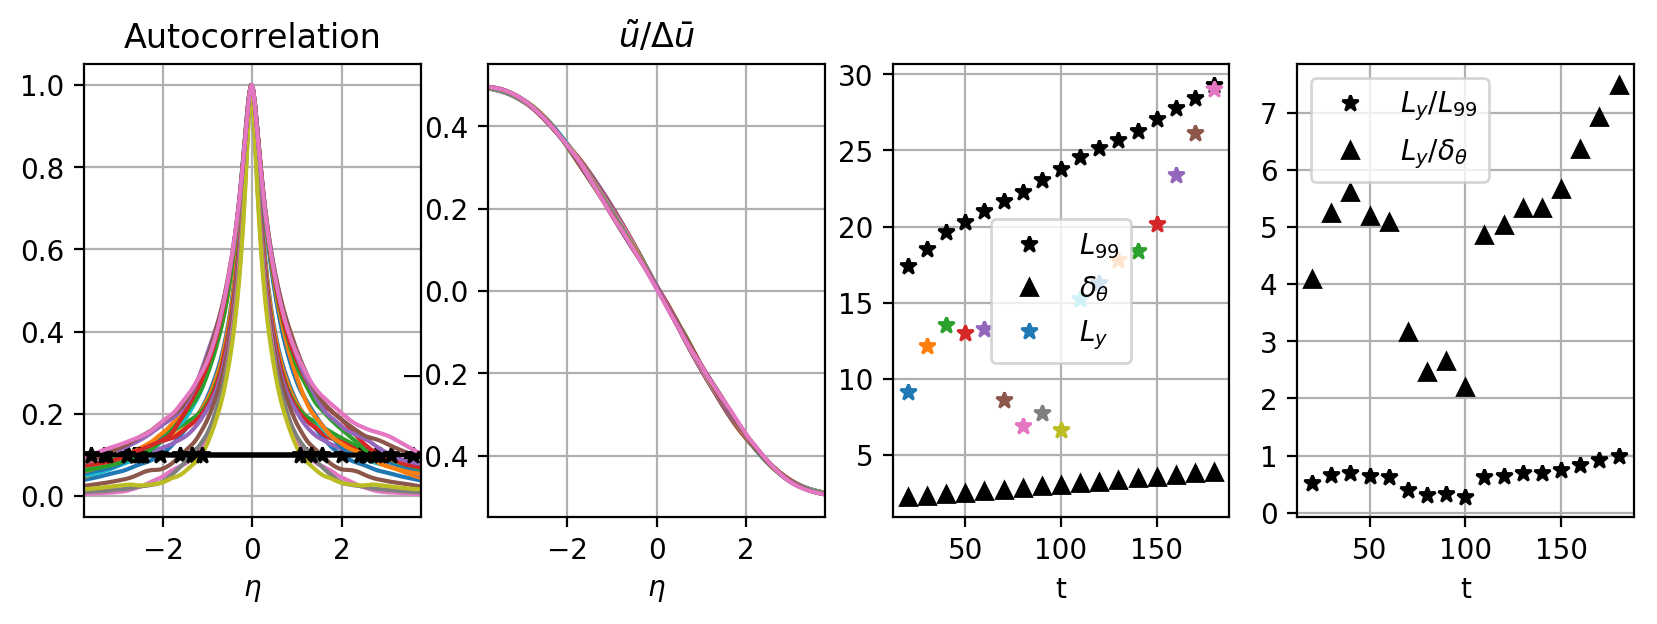

In [7]:

plot_lscale(directory,flist[0:-1],ist=0,ien=-1,thresh=0.1)
# plot_lscale_xz(directory,flist[2:13],corr_dir='z',ist=0,ien=-4)

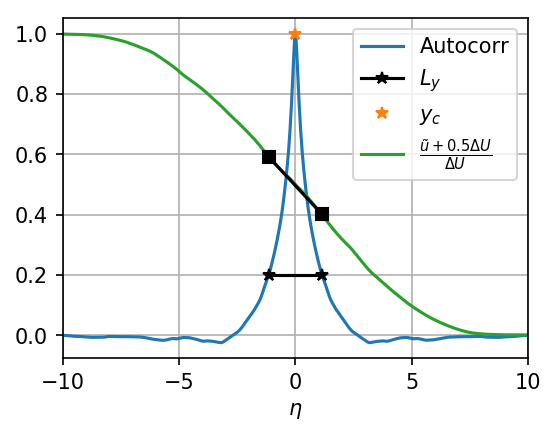

In [35]:
# Get decorrelation length
def get_lscale(y,Lvv,thresh=0.20):
    Ny = np.size(Lvv)
    imax0 = np.argmax(Lvv)
    
    # find inflection point
    dLdx = (Lvv[:-1:]-Lvv[1::])/abs(y[0]-y[1])
    asign = np.sign(dLdx)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    imax1,imax2=None,None

    for i in range(1,Ny/4):
        if signchange[imax0-i]==1:
            imax1 = imax0-i
            break
    for i in range(1,Ny/4):
        if signchange[imax0+i]==1:
            imax2 = imax0+i
            break
    if (imax1 is None):
        #print('Error finding inflection points 1')
        imax1 = 0
    if (imax2 is None):
        #print('Error finding inflection points 2')
        imax2 = Ny-1
    i1 = np.argmin(abs(Lvv[imax1:imax0]-thresh)) + imax1
    i2 = np.argmin(abs(Lvv[imax0:imax2]-thresh)) + imax0
    L = abs(y[i1]-y[i2])
    return L,i1,i2, imax0


fname = flist[-1]
tID = fname.split('_')[-1]
tID = tID.split('.dat')[0]
time = nml.read_time(directory,tID)

# Get eta
dtheta = get_dtheta(directory,time)
eta = y/dtheta

# Get transverse decorr lengthscale
autocorr = np.fromfile(fname, sep=' ',count=-1)
autocorr = np.reshape(autocorr,[Ny,3])
autocorr = autocorr[:,0] #[yc,yc+offset,yc-offset]
ly,i1,i2,imax0 = get_lscale(y,autocorr,thresh=0.2)
# ax[0].plot(eta, autocorr,alpha=1,label='tID=%s,t=%d'%(tID,time))

fig = plt.figure(figsize=(4,3),dpi=150)
eta -= y[imax0]/dtheta
plt.plot(eta,autocorr,label='Autocorr')
plt.plot([eta[i1],eta[i2]],[0.2,0.2],'k-*',label='$L_y$')
plt.plot(eta[imax0],autocorr[imax0],'*',label='$y_c$')
plt.grid(True)

utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
utilde = (utilde+0.5*inp.du)/inp.du
plt.plot(eta,utilde,label=r'$\frac{\tilde{u}+0.5\Delta U}{\Delta U}$')
plt.plot([eta[i1],eta[i2]],[utilde[i1],utilde[i2]],'k-s')


plt.xlim([-10,10])
plt.xlabel('$\eta$')
plt.legend()

In [520]:
s = '1'

if s=='1': Mc_list =['20',]# ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    

fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    z = np.linspace(0,Lz,Nz)
    x = np.linspace(0,Lx,Nx)
    y = np.linspace(Ly/2.,-Ly/2.,Ny)

    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'
    
    if Mc=='02': ist=9;ien=-1
    elif Mc=='04': ist=2;ien=13-4
    else: ist=0; ien=-1
        
    q = 'v'
    flist = glob.glob(dir_out+"*lscale_{}{}*".format(q,q))
    flist.sort()
    for corr_dir in ['x','y','z']:
        savename='/home/kmatsuno/ShearLayer_img/lscale_{}/profile_Mc{}_s{}_{}.png'.format(q,Mc,s,corr_dir)
        if corr_dir=='y':plot_lscale(directory,flist[ist:ien],savename=savename)
        else: plot_lscale_xz(directory,flist[ist:ien],corr_dir=corr_dir,savename=savename)

Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_x.png
Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_y.png
Saved to /home/kmatsuno/ShearLayer_img/lscale_v/profile_Mc20_s1_z.png


<Figure size 750x450 with 0 Axes>